In [1]:
#Nama : Fahmi Nurrahim (19917003)


# IMPORT LIBRARY
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import numpy as np 

Using TensorFlow backend.


In [45]:
np.random.seed(7)

In [46]:
# IMPORT DATASET, dataset dapat di akses open melalui komunitas apple
dataset = pd.read_csv('stok_item_Apple.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])

In [47]:
# membuat index label dengan array numpy
obs = np.arange(1, len(dataset) + 1, 1)

In [48]:
# menentukan kolom yang digunakan untuk prediksi
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

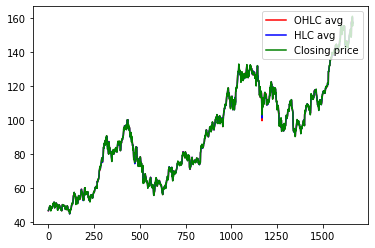

In [49]:
# menggabungkan semua kolom indikator kedalam satu plot sebagai visual
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [50]:
# merupakan indikator waktu yg digunakan (timestamp)
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [51]:
# membagi data train dan tes dengan pembagian 75 - 25
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [52]:
# bagian ini digunakan untuk menginisialisasi data time series pada array
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [53]:
# membagi data time series pada masing2 data test dan train
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [54]:
# merepresentasikan data ke dalam array numpy
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [55]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [57]:
# implementasi model dengan data training dengan menggunakan 5 epoch
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)


# dari percobaan epoch 5, 10, 15 dan 20, menunjukan hasil bahwa epoch 20 memiliki nilai loss yang paling kecil dengan loss : 1.1529e-04

Epoch 1/20
 - 6s - loss: 1.8257e-04
Epoch 2/20
 - 5s - loss: 1.3322e-04
Epoch 3/20
 - 5s - loss: 1.2810e-04
Epoch 4/20
 - 5s - loss: 1.2329e-04
Epoch 5/20
 - 6s - loss: 1.2237e-04
Epoch 6/20
 - 5s - loss: 1.1917e-04
Epoch 7/20
 - 5s - loss: 1.1914e-04
Epoch 8/20
 - 5s - loss: 1.1871e-04
Epoch 9/20
 - 5s - loss: 1.2045e-04
Epoch 10/20
 - 5s - loss: 1.1949e-04
Epoch 11/20
 - 5s - loss: 1.1765e-04
Epoch 12/20
 - 5s - loss: 1.1681e-04
Epoch 13/20
 - 5s - loss: 1.1722e-04
Epoch 14/20
 - 5s - loss: 1.1757e-04
Epoch 15/20
 - 5s - loss: 1.1726e-04
Epoch 16/20
 - 5s - loss: 1.1784e-04
Epoch 17/20
 - 5s - loss: 1.1619e-04
Epoch 18/20
 - 6s - loss: 1.1735e-04
Epoch 19/20
 - 5s - loss: 1.1743e-04
Epoch 20/20
 - 5s - loss: 1.1529e-04


In [58]:
# inisialisasi prediksi terhadap data test dan train
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [59]:
# normalisasi nilai agar mudah dijadikan plot
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [60]:
# nilai training RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.23


In [61]:
# nilai test RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 1.67


In [62]:
# bagian ini untuk membuat plot training prediksi 
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [63]:
# bagian ini untuk membuat plot test prediksi 
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [64]:
# normalisasi nilai kembali
OHLC_avg = scaler.inverse_transform(OHLC_avg)

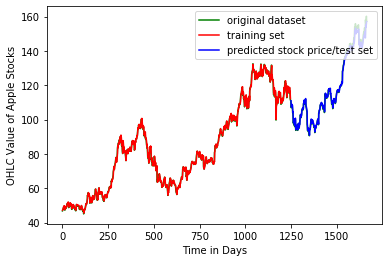

In [65]:
# menjadikan satu plot antara niali OHLC, train prediksi dan test prediksi
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [66]:
# prediksi nilai pada masa mendatang
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))
print (np.append(last_val, next_val))

Last Day Value: 156.9837188720703
Next Day Value: 152.6326446533203
[156.98372      0.97228324]
